11.865396825396825


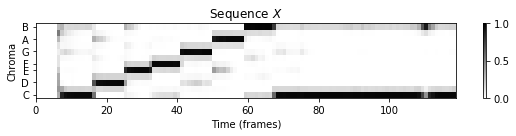

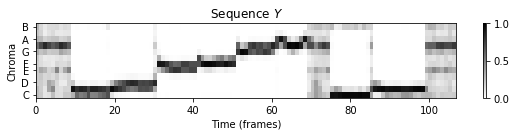

In [138]:
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
%matplotlib inline

import sys
sys.path.append('..')
import libfmp.c3

Fs = 22050

# song_file_name = 'Shell-of-What-Was_15.wav'
# humming_file_name = 'Shell-of-What-Was_15_record.wav'

song_file_name = 'reference_8.wav'
humming_file_name = 'song_8_2.wav'
# humming_file_name = 'C_major.wav'

song = os.path.join('..', 'data', song_file_name)
humming = os.path.join('..', 'data', humming_file_name)
# print(fn_wav_X)

X_wav, Fs = librosa.load(song, sr=Fs)

#computing harmonic part of audio source
D = librosa.stft(X_wav)
H, P  = librosa.decompose.hpss(D, margin = 2.0)    # decomposing into harmonic and percussive waveforms.
X_harmonic = librosa.istft(H)  

X_wav = X_harmonic
Y_wav, Fs = librosa.load(humming, sr=Fs)

print(librosa.get_duration(X_wav))

# print("change")
N = 4410
H = 2205


X = librosa.feature.chroma_stft(y=X_wav, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
Y = librosa.feature.chroma_stft(y=Y_wav, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)

plt.figure(figsize=(8, 2))
plt.title('Sequence $X$')
librosa.display.specshow(X, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
plt.xlabel('Time (frames)')
plt.ylabel('Chroma')
plt.colorbar()
plt.clim([0, 1])
plt.tight_layout(); plt.show()
ipd.display(ipd.Audio(X_wav, rate=Fs))

plt.figure(figsize=(8, 2))
plt.title('Sequence $Y$')
librosa.display.specshow(Y, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
plt.xlabel('Time (frames)')
plt.ylabel('Chroma')
plt.colorbar()
plt.clim([0, 1])
plt.tight_layout(); plt.show()
ipd.display(ipd.Audio(Y_wav, rate=Fs))

In [2]:
# pitch comparison for simple tunes

# print(X_wav.shape)
f0, voiced_flag, voiced_probs = librosa.pyin(X_wav, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
f1, voiced_flag, voiced_probs = librosa.pyin(Y_wav, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

np.warnings.filterwarnings('ignore')

print(np.max(f0[f0 > 0]) / np.min(f0[f0 > 0]))
print(np.max(f1[f1 > 0]) / np.min(f1[f1 > 0]))



8.09295552241538
5.401399784672761


In [5]:
#tempo information
tempo_X, _ = librosa.beat.beat_track(y=X_wav, sr=Fs)
tempo_Y, _ = librosa.beat.beat_track(y=Y_wav, sr=Fs)
print("song to humming tempo ratio : ", tempo_X/tempo_Y)

song to humming tempo ratio :  0.7837837837837839


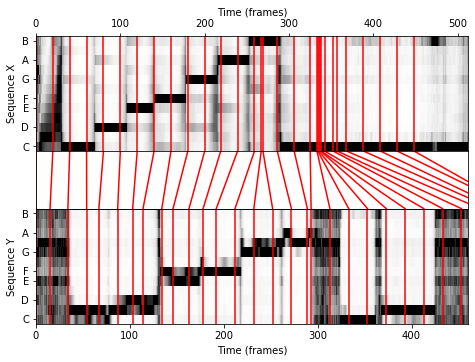

459
mean of accuracy  0.7327656376486142


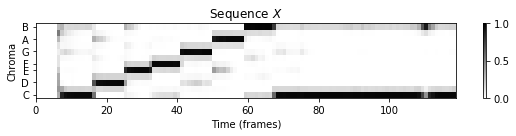

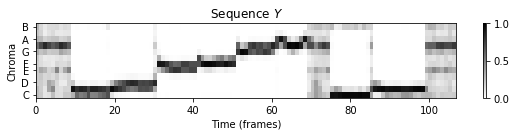

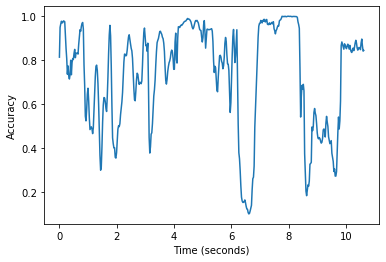

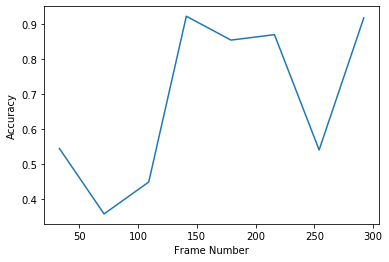

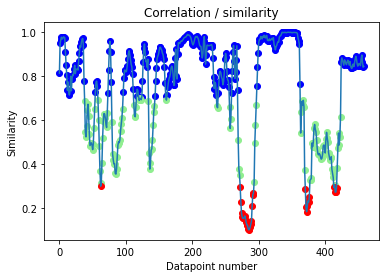

In [139]:
def max_of_neighbors(arr, k):
    n = len(arr)
    res = []
    for i in range(n):
        left = max(0, i - k)
        right = min(n - 1, i + k)
        neighbors = arr[left:right+1]
        res.append(max(neighbors))
    return res


def find_local_minimas(arr, k):
    n = len(arr)
    minimas = []
    for i in range(k-1, n-k+1):
        if all(arr[i] < arr[j] for j in range(i-k+1, i+1)) and all(arr[i] < arr[j] for j in range(i+1, i+k)):
            minimas.append(arr[i])
    return minimas


def plot_piecewise_accuracy(user_humming_file, reference_melody_file, window_size=1024, hop_size=1, Fs = 22050):
    # Load the user humming and reference melody files
    user_humming, Fs = librosa.load(user_humming_file, sr = Fs)
    reference_melody, Fs = librosa.load(reference_melody_file, sr = Fs)
    
    D = librosa.stft(reference_melody)
    H, P  = librosa.decompose.hpss(D, margin = 2.0)    # decomposing into harmonic and percussive waveforms.
    harmonic = librosa.istft(H)
#     reference_melody = harmonic
    
    user_onset_env = librosa.onset.onset_strength(user_humming, sr=Fs)
    user_onset_frames = librosa.onset.onset_detect(onset_envelope=user_onset_env, sr=Fs)
    
    reference_onset_env = librosa.onset.onset_strength(reference_melody, sr=Fs)
    reference_onset_frames = librosa.onset.onset_detect(onset_envelope=reference_onset_env, sr=Fs)
    
    humming_time = librosa.get_duration(user_humming, Fs)
    reference_time = librosa.get_duration(reference_melody, Fs)

    
#     print(user_humming, reference_melody)
    # Compute the chromagram of the reference melody
    reference_chroma = librosa.feature.chroma_cqt(y=reference_melody, sr=Fs)
#     print(reference_chroma.shape, reference_chroma)
    
    # Compute the chromagram of the user humming
    user_chroma = librosa.feature.chroma_cqt(y=user_humming, sr=Fs)
    
    time_per_frame = humming_time / user_chroma.shape[1]
    reference_tpf = reference_time / reference_chroma.shape[1]
    
    C = libfmp.c3.compute_cost_matrix(user_chroma, reference_chroma)
    D = libfmp.c3.compute_accumulated_cost_matrix(C)
    P = libfmp.c3.compute_optimal_warping_path(D)
    
################################### showing Optimal warping Path ###################################
    ax_X = plt.axes([0, 0.60, 1, 0.40])
    librosa.display.specshow(reference_chroma, ax=ax_X, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
    ax_X.set_ylabel('Sequence X')
    ax_X.set_xlabel('Time (frames)')
    ax_X.xaxis.tick_top()
    ax_X.xaxis.set_label_position('top') 

    ax_Y = plt.axes([0, 0, 1, 0.40])
    librosa.display.specshow(user_chroma, ax=ax_Y, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
    ax_Y.set_ylabel('Sequence Y')
    ax_Y.set_xlabel('Time (frames)')

    step = 20
    y_min_X, y_max_X = ax_X.get_ylim()
    y_min_Y, y_max_Y = ax_Y.get_ylim()
    for t in P[0:-1:step, :]: 
        ax_X.vlines(t[0], y_min_X, y_max_X, color='r')
        ax_Y.vlines(t[1], y_min_Y, y_max_Y, color='r')

    ax = plt.axes([0, 0.40, 1, 0.20])
    for p in P[0:-1:step, :]: 
    #     print(p)
        ax.plot((p[0]/reference_chroma.shape[1], p[1]/user_chroma.shape[1]), (1, -1), color='r')
        ax.set_xlim(0, 1)
        ax.set_ylim(-1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    
    user_frame_to_reference_frame_mapping = {}
    for p in P[0:-1, :]:
        b = p[0]
        a = p[1]
        if b in user_frame_to_reference_frame_mapping:
            user_frame_to_reference_frame_mapping[b].append(a)
        else:
            user_frame_to_reference_frame_mapping[b] = [a]
    print(len(user_frame_to_reference_frame_mapping))
#     print(user_chroma.shape[1])
#     print(time_per_frame)

    time_points = [ i * time_per_frame for i in range(len(user_chroma[1])) ]

    # Initialize an array to store the accuracy at each time point
    accuracy = np.zeros(len(time_points))
    onset_accuracy = []
    user_onset_frames = []
    
    
#################################### frame mapping and similarity calculation ##################################
    for frame_no in range(len(user_frame_to_reference_frame_mapping)):
        
        melody_frames = user_frame_to_reference_frame_mapping[frame_no]
        similarity = 0
        user_data = user_chroma[:, frame_no]
        j = 0
        for frame in melody_frames:
            j += 1
            reference_data = reference_chroma[:, frame]
#             temp_similarity = (np.dot(user_data, reference_data) / (np.linalg.norm(user_data) * np.linalg.norm(reference_data) ) )
#             if temp_similarity > similarity:
#                 similarity = temp_similarity
            similarity += np.dot(user_data, reference_data) / (np.linalg.norm(user_data) * np.linalg.norm(reference_data) )
                
            if frame in reference_onset_frames:
                onset_accuracy.append(similarity / j)
                user_onset_frames.append(frame)
        similarity /= len(melody_frames)
        accuracy[frame_no] = similarity
        
        
    print("mean of accuracy ", np.mean(accuracy))

    

########################## showing ipython display for worst accuracy parameter ################################
    sorted_indices = np.asarray(onset_accuracy).argsort()
    least_index = sorted_indices[0]
    
    reference_index = user_frame_to_reference_frame_mapping[least_index]
#     print(second_least_index)
    

    start_time = least_index * time_per_frame
    audio_start = max(0, start_time - 1)
    audio_end = min(humming_time, start_time + 1)
    
    reference_start_time = reference_index[0] * reference_tpf
    ref_audio_start = max(0, (reference_index[0] * reference_tpf) - 1)
    ref_audio_end = min(reference_time, (reference_index[-1] * reference_tpf) + 1)
    
#     print("audio start, end", audio_start, audio_end)
    start_sample = int(audio_start * Fs)
    end_sample = start_sample + int( ( audio_end - audio_start ) * Fs)
    audio_clip = user_humming[start_sample:end_sample]
    
    ref_start_sample = int(ref_audio_start * Fs)
    ref_end_sample = ref_start_sample + int( (ref_audio_end - ref_audio_start) * Fs )
    ref_audio_clip = reference_melody[ref_start_sample:ref_end_sample]
    

##################################################################################################
    
############################################# Plotting graphs ####################################
    
    indices_low = np.where(accuracy < 0.3)
    indices_medium = np.where(accuracy >= 0.3)
    indices_medium = np.where(indices_medium[0] < 0.7)
    indices_red = np.where(accuracy >= 0.7)
    
    plt.figure(figsize=(8, 2))
    plt.title('Sequence $X$')
    librosa.display.specshow(X, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
    plt.xlabel('Time (frames)')
    plt.ylabel('Chroma')
    plt.colorbar()
    plt.clim([0, 1])
    plt.tight_layout(); plt.show()
    ipd.display(ipd.Audio(user_humming, rate=Fs))
    
    plt.figure(figsize=(8, 2))
    plt.title('Sequence $Y$')
    librosa.display.specshow(Y, x_axis='frames', y_axis='chroma', cmap='gray_r', hop_length=H)
    plt.xlabel('Time (frames)')
    plt.ylabel('Chroma')
    plt.colorbar()
    plt.clim([0, 1])
    plt.tight_layout(); plt.show()
    ipd.display(ipd.Audio(reference_melody, rate=Fs))
    
    plt.plot(time_points[:-1], accuracy[:-1])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.plot(user_onset_frames, onset_accuracy)
    plt.xlabel('Frame Number')
    plt.ylabel('Accuracy')
    plt.show()

    fig, ax = plt.subplots()
    less_than_threshold = [i for i, val in enumerate(accuracy[:-1]) if val<0.3]
    between_threshold = [i for i, val in enumerate(accuracy[:-1]) if val>=0.3 and val < 0.7]
    greater_than_threshold = [i for i, val in enumerate(accuracy[:-1]) if val>=0.7]
    plt.title('Correlation / similarity')
    plt.xlabel('Datapoint number')
    plt.ylabel('Similarity')
    ax.plot(greater_than_threshold, accuracy[greater_than_threshold], linestyle='none', color='b', marker='o')
    ax.plot(between_threshold, accuracy[between_threshold], linestyle='none', color='#90EE90', marker='o')
    ax.plot(less_than_threshold, accuracy[less_than_threshold], linestyle='none', color='r', marker='o')
    ax.plot(accuracy[:-1])
    plt.show()
    

    
    ipd.display(ipd.Audio(audio_clip, rate=Fs))
    ipd.display(ipd.Audio(ref_audio_clip, rate=Fs))
    
plot_piecewise_accuracy(humming, song)


